# <center>Predictive Modeling of Cryptocurrency Prices Using Regression Analysis</center>

## Introduction

Cryptocurrency markets are known for their dynamic and volatile nature, making them a challenging yet intriguing domain for traders, investors, and analysts. In this project, we aim to leverage predictive modeling techniques to forecast future cryptocurrency prices.

## Background

Cryptocurrencies have become a significant part of the global financial landscape, with Bitcoin leading the way as the pioneer and several others emerging as valuable assets. Understanding and predicting price movements in this market is crucial for effective decision-making.

## Motivation

The motivation behind this project stems from the need to provide stakeholders in the cryptocurrency space with accurate and reliable price predictions. By harnessing the power of machine learning, we aim to contribute insights that can enhance decision-making processes and mitigate risks associated with cryptocurrency investments.

## Business Problem

The dynamic nature of cryptocurrency markets poses challenges for traders and investors to make informed decisions. Our project addresses the need for a predictive model that can navigate the complexities of cryptocurrency price movements, aiding in strategic decision-making.

## Modeling Approach

We will employ regression analysis, specifically time series and regression techniques, to develop models capable of capturing the intricate patterns in cryptocurrency price data. These models will leverage historical price trends and other relevant factors to make accurate predictions.

## Assumptions

- We assume that historical price trends in cryptocurrencies have some level of predictive ability.
- Acknowledging the volatility of cryptocurrency markets, we understand that achieving high prediction accuracy is challenging.
- Unforeseen events or news that can rapidly impact cryptocurrency values may not be explicitly considered in this model.

## CRISP-DM Framework

To structure our approach, we will follow the Cross-Industry Standard Process for Data Mining (CRISP-DM). This framework includes phases such as business understanding, data understanding, data preparation, modeling, evaluation, and deployment.

## Conclusion

This project aims to enhance our understanding of cryptocurrency price movements through advanced predictive modeling. By combining historical data with machine learning techniques, we strive to provide valuable insights for navigating the unpredictable world of cryptocurrency trading and investment.


## 1. Importing Necessary libraries

In [ ]:
pip install --upgrade yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.32
    Uninstalling yfinance-0.2.32:
      Successfully uninstalled yfinance-0.2.32


In [ ]:
import yfinance as yf

import numpy as np
import pandas as pd
from math import sqrt
from pandas import DataFrame
from pandas import read_csv
from pandas import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from statsmodels.tsa.arima.model import ARIMA

<ipython-input-2-593798f2f70b>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 2. Download Bitcoin Historical Data

In [ ]:
# Download historical data
main = yf.download("BTC-USD", start="2014-09-17", end="2023-12-11")

# Print the first few rows of the data
main.head()

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100

Acquiring and preparing the Bitcoin dataset for analysis  retrieved from the Yahoo historical data section of the Bitcoin USD (BTC-USD) page, involving data cleaning and normalization (Yahoo!, 2023).


In [ ]:
data = main.copy()

In [ ]:
data.shape

(3372, 6)

## 3. Feature Engineering
This section calculates essential technical indicators  to analyze the daily price movements of the financial instrument in the dataset:
 - These technical indicators are important tools for traders and analysts to assess the market's current state, potential trend changes, and overbought/oversold conditions.
 - They can be used individually or in combination with other indicators to make more informed trading and investment decisions. Keep in mind that while these indicators provide valuable insights, they should be used alongside other forms of analysis, risk management, and a clear trading strategy.

In [ ]:
# Extract Date Components
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
data['DayOfWeek'] = data.index.dayofweek

In [ ]:
# Calculate daily price change and percentage change
data['PriceChange'] = data['Adj Close'].diff()
data['PriceChangePercentage'] = data['Adj Close'].pct_change() * 100

# Calculate daily returns
data['Daily_Return'] = data['Adj Close'].pct_change() * 100

**Simple Moving Average (SMA)**:
The Simple Moving Average (SMA) is a trend-following indicator that calculates the arithmetic mean of closing prices over a specified period. It smooths out price data to identify trends. SMA crossovers signal potential trend reversals or continuations.

**Formula:**
The SMA is calculated as follows:
 - SMA = (Sum of prices over n periods) / n

In [ ]:
# Calculate moving averages
data['SMA_14'] = data['Adj Close'].rolling(window=14).mean()

**Exponential Moving Average (EMA)**:
EMA is a responsive moving average that gives more weight to recent prices, making it effective for capturing short-term price changes and trends.

**Importance:**
- **Responsiveness:** EMA reacts quickly to price movements, making it useful for identifying forming or changing trends.

**Formula**:
 - EMA = (Current Price * (2 / (1 + n)) + Previous EMA * (1 - 2 / (1 + n))

**MACD (Moving Average Convergence Divergence)**:
MACD is a trend-following momentum indicator that consists of the MACD line (the difference between two EMAs) and the signal line (a 9-day EMA of the MACD line). It helps identify potential changes in trend direction and momentum in financial instruments.

**Importance:**
- **Bullish Signal:** MACD line crossing above the signal line indicates potential upward momentum.
- **Bearish Signal:** MACD line crossing below the signal line suggests potential downward momentum.

**Formula**
 - MACD = Short-term EMA - Long-term EMA

In [ ]:
# Calculate the Moving Average Convergence Divergence (MACD)
data['ShortEMA'] = data['Adj Close'].ewm(span=7, adjust=False).mean()
data['LongEMA'] = data['Adj Close'].ewm(span=30, adjust=False).mean()
data['MACD'] = data['ShortEMA'] - data['LongEMA']

**Relative Strength Index (RSI)**:
RSI is a momentum oscillator that measures the speed and change of price movements, ranging from 0 to 100. Values above 70 suggest overbought conditions (potential sell signals), while values below 30 indicate oversold conditions (potential buy signals).

- **Momentum Assessment:** RSI helps assess the overextension of an asset in one direction, providing insights into potential reversals or corrections.

**Formula**:
 - RSI = 100 - (100 / (1 + RS))
 - RS (Relative Strength) = Average Gain / Average Loss
 - Average Gain = (Sum of gains over n periods) / n
 - Average Loss = (Sum of losses over n periods) / n


In [ ]:
# Calculate the Relative Strength Index (RSI)
rsi_window = 14
delta = data['Adj Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=rsi_window).mean()
avg_loss = loss.rolling(window=rsi_window).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

**Bollinger Bands**:
Bollinger Bands consist of a centerline (SMA) and upper and lower bands representing standard deviations of price movements. These bands expand and contract with volatility changes. Proximity to upper or lower bands may suggest overbought or oversold conditions, while band narrowing can signal potential breakouts.

- **Volatility Indicator:** Bollinger Bands indicate volatility, helping identify potential price breakouts and reversals.

**Formulas:**
- Upper Band = SMA + (Multiplier * Standard Deviation)
- Lower Band = SMA - (Multiplier * Standard Deviation)

*Note: Multiplier and period for standard deviation are adjustable parameters.*


In [ ]:
# Calculate Bollinger Bands
data['RollingMean_14'] = data['Adj Close'].rolling(window=14).mean()
data['RollingStd_14'] = data['Adj Close'].rolling(window=14).std()
data['UpperBand_14'] = data['RollingMean_14'] + (2 * data['RollingStd_14'])
data['LowerBand_14'] = data['RollingMean_14'] - (2 * data['RollingStd_14'])

**Calculate True Range (TR)**:
True Range (TR) is a measure of price volatility that considers the greatest of the following three ranges for each period: High minus Low (HL), absolute value of High minus the previous day's Close (HC), and absolute value of Low minus the previous day's Close (LC).

**Calculations**:
- **HL (High-Low):** The absolute difference between High and Low prices.
- **HC (High-Close):** Absolute value of the difference between High and the previous day's Close.
- **LC (Low-Close):** Absolute value of the difference between Low and the previous day's Close.
- **TR (True Range):** Maximum value among HL, HC, and LC for each period.

In [ ]:
# Calculate True Range (TR)
data['HL'] = data['High'] - data['Low']
data['HC'] = abs(data['High'] - data['Adj Close'].shift(1))
data['LC'] = abs(data['Low'] - data['Adj Close'].shift(1))
data['TR'] = data[['HL', 'HC', 'LC']].max(axis=1)

**Williams %R**:
Williams %R is a momentum oscillator that helps identify overbought and oversold conditions in the market. It is calculated based on the highest high and lowest low over a specified period.

**Calculations**:
- **Highest High:** Maximum high price in the last 14 periods.
- **Lowest Low:** Minimum low price in the last 14 periods.
- **%R:** The Williams %R value, indicating the percentage position of the current close relative to the highest high and lowest low.


In [ ]:
# Calculate the Highest and Lowest Periods
data['Highest High'] = data['High'].rolling(window=14).max()
data['Lowest Low'] = data['Low'].rolling(window=14).min()

# Calculate Williams %R
data['%R'] = ((data['Highest High'] - data['Adj Close']) / (data['Highest High'] - data['Lowest Low'])) * -100

**Create Target for Next Close Price**:
To facilitate supervised machine learning, a target variable for the next day's closing price is created. This involves shifting the 'Adj Close' prices by one day to align each current day's features with the next day's closing price.

In [ ]:
# Create target variable for the next day's closing price
data['TargetNextClose'] = data['Adj Close'].shift(-1)

Forecasting Bitcoin is challenging due to volatility. Blockchain impacts finance significantly. Traditional models struggle, leading to increased use of machine learning and technical indicators from [PrimeXBT](https://primexbt.com/for-traders/best-indicators-for-cryptocurrency-trading/). Achieving precise predictions remains a challenge, emphasizing machine learning limitations (Levi, 2023).


## 4. Exploratory Data Analysis (EDA)

In [ ]:
# Display the first few rows of the DataFrame
data.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  Year  Month  Day  DayOfWeek  ...  UpperBand_14  \
Date                                               ...                 
2014-09-17  21056800  2014      9   17          2  ...           NaN   
2014-09-18  34483200  2014      9   18          3  ...           NaN   
2014-09-19  37919700  2014      9   19          4  ...           NaN   
2014-09-20  36863600  2014      9   20          5  ...           NaN   
2014-09-21  26580100  2014      9   21          6  ...           NaN   

            LowerBand_14         HL         HC         LC         TR  \
Date                                                                   
2014-09-17           NaN  15.752014        NaN        NaN  15.752014   
2014-09-18           NaN  43.755981   0.474030  44.230011  44.230011   
2014-09-19           NaN  43.302979   3.394989  39.907990  43.302979   
2014-09-20           NaN  33.412994  28.500000   4.912994  33.412994   
2014-09-21           NaN  19.244995   3.522003  15.722992  19.244995   

            Highest High  Lowest Low  %R  TargetNextClose  
Date                                                       
2014-09-17           NaN         NaN NaN       424.440002  
2014-09-18           NaN         NaN NaN       394.795990  
2014-09-19           NaN         NaN NaN       408.903992  
2014-09-20           NaN         NaN NaN       398.821014  
2014-09-21           NaN         NaN NaN       402.152008  

[5 rows x 30 columns]

In [ ]:
# Display concise summary of DataFrame information
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3372 entries, 2014-09-17 to 2023-12-10
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   3372 non-null   float64
 1   High                   3372 non-null   float64
 2   Low                    3372 non-null   float64
 3   Close                  3372 non-null   float64
 4   Adj Close              3372 non-null   float64
 5   Volume                 3372 non-null   int64  
 6   Year                   3372 non-null   int64  
 7   Month                  3372 non-null   int64  
 8   Day                    3372 non-null   int64  
 9   DayOfWeek              3372 non-null   int64  
 10  PriceChange            3371 non-null   float64
 11  PriceChangePercentage  3371 non-null   float64
 12  Daily_Return           3371 non-null   float64
 13  SMA_14                 3359 non-null   float64
 14  ShortEMA               3372 non-null  

In [ ]:
# Generate descriptive statistics of the DataFrame
data.describe()

Open          High           Low         Close     Adj Close  \
count   3372.000000   3372.000000   3372.000000   3372.000000   3372.000000   
mean   14396.650403  14735.425405  14033.004480  14408.166309  14408.166309   
std    16083.223947  16473.187636  15647.991730  16086.375625  16086.375625   
min      176.897003    211.731003    171.509995    178.102997    178.102997   
25%      903.225250    918.869247    886.839752    906.414490    906.414490   
50%     8204.144043   8334.787598   7979.954834   8205.654297   8205.654297   
75%    23314.387207  23789.486328  22898.128906  23332.885254  23332.885254   
max    67549.734375  68789.625000  66382.062500  67566.828125  67566.828125   

             Volume         Year       Month          Day    DayOfWeek  ...  \
count  3.372000e+03  3372.000000  3372.00000  3372.000000  3372.000000  ...   
mean   1.651018e+10  2018.817319     6.62159    15.731020     3.001483  ...   
std    1.913173e+10     2.674438     3.46278     8.806888     1.999925  ...   
min    5.914570e+06  2014.000000     1.00000     1.000000     0.000000  ...   
25%    1.529695e+08  2017.000000     4.00000     8.000000     1.000000  ...   
50%    1.111905e+10  2019.000000     7.00000    16.000000     3.000000  ...   
75%    2.691100e+10  2021.000000    10.00000    23.000000     5.000000  ...   
max    3.509679e+11  2023.000000    12.00000    31.000000     6.000000  ...   

       UpperBand_14  LowerBand_14            HL           HC            LC  \
count   3359.000000   3359.000000   3372.000000  3371.000000   3371.000000   
mean   15835.904743  12925.687569    702.420925   340.542307    363.413921   
std    17669.185776  14451.816334   1103.545415   653.067076    793.573254   
min      233.139680    159.857481      1.028000     0.000000      0.001984   
25%     1026.713654    792.814476     33.704529    10.048325      7.832397   
50%     9207.815339   7131.130734    271.435425    80.805664     77.510010   
75%    25098.529877  21027.859374    839.658203   353.225586    345.488770   
max    69521.721591  60099.636006  12864.621094  7300.488281  12227.906250   

                 TR  Highest High    Lowest Low           %R  TargetNextClose  
count   3372.000000   3359.000000   3359.000000  3359.000000      3371.000000  
mean     703.086530  15835.183348  12862.764578   -45.272592     14412.304794  
std     1104.266735  17639.944321  14327.734137    30.006260     16086.966711  
min        1.028000    233.251999    171.509995  -100.000000       178.102997  
25%       33.840988   1032.630005    789.173004   -71.892887       907.644501  
50%      272.593140   9164.362305   7262.410156   -44.228054      8205.939453  
75%      841.133301  25134.117188  20856.730469   -16.521045     23333.922852  
max    12864.621094  68789.625000  60163.781250    -0.000000     67566.828125  

[8 rows x 30 columns]

**a. Data Cleaning**

In [ ]:
# Count the number of missing values in each column
data.isnull().sum()

Open                      0
High                      0
Low                       0
Close                     0
Adj Close                 0
Volume                    0
Year                      0
Month                     0
Day                       0
DayOfWeek                 0
PriceChange               1
PriceChangePercentage     1
Daily_Return              1
SMA_14                   13
ShortEMA                  0
LongEMA                   0
MACD                      0
RSI                      13
RollingMean_14           13
RollingStd_14            13
UpperBand_14             13
LowerBand_14             13
HL                        0
HC                        1
LC                        1
TR                        0
Highest High             13
Lowest Low               13
%R                       13
TargetNextClose           1
dtype: int64

In [ ]:
# Drop rows with missing values from the DataFrame
data = data.dropna()

In [ ]:
# Display the shape of the DataFrame (number of rows and columns)
data.shape

(3358, 30)

**b. To Extract date range of the dataframe**

In [ ]:
# Create a datetime column from 'Year', 'Month', and 'Day'
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Print the first and last date
first_date = data['Date'].min()
last_date = data['Date'].max()

print("First Date:", first_date)
print("Last Date:", last_date)

First Date: 2014-09-30 00:00:00
Last Date: 2023-12-09 00:00:00


**c. Volume Statistics and Visualization**

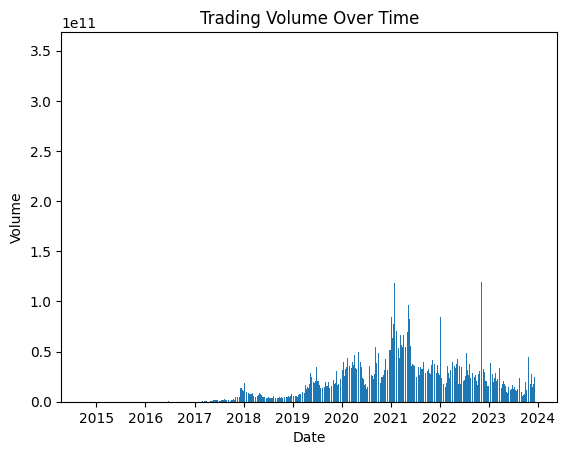

In [ ]:
# Calculate basic statistics for volume
volume_stats = data['Volume'].describe()

# Visualize volume using a bar chart
plt.bar(data['Date'], data['Volume'])
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Trading Volume Over Time')
plt.show()

**d. Analyze Target Variable Distribution (TargetNextClose)**

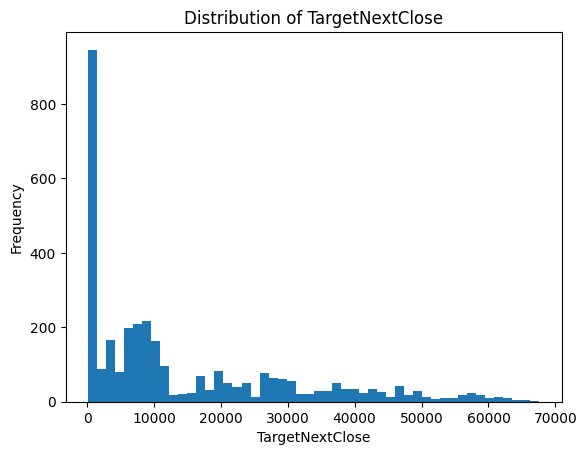

In [ ]:
# Analyze the distribution of the target variable (TargetNextClose)
close_next_stats = data[data['TargetNextClose'] != 0]['TargetNextClose'].describe()

# Visualize the target variable
plt.hist(data['TargetNextClose'], bins=50)
plt.xlabel('TargetNextClose')
plt.ylabel('Frequency')
plt.title('Distribution of TargetNextClose')
plt.show()

**e. Technical Indicators and Intraday Range Analysis**

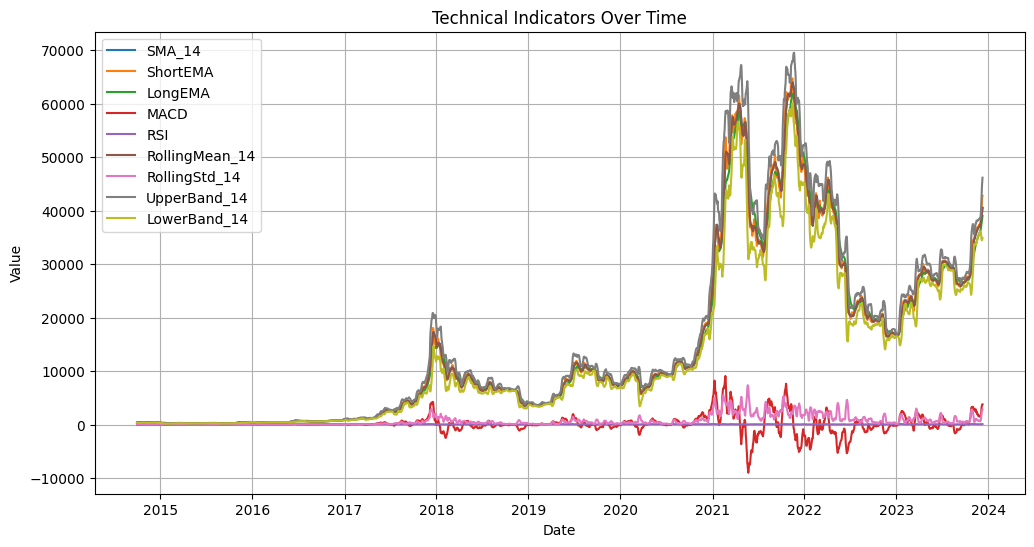

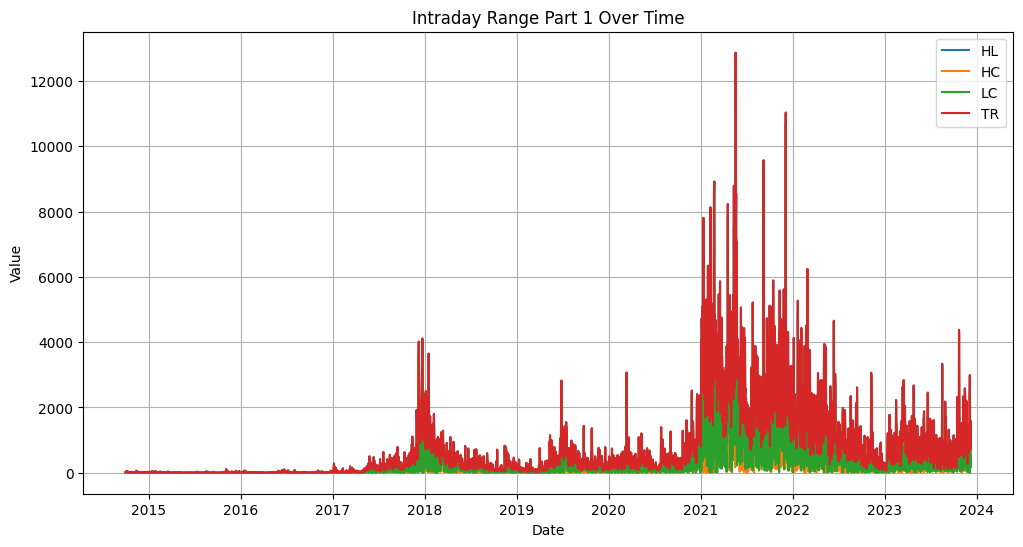

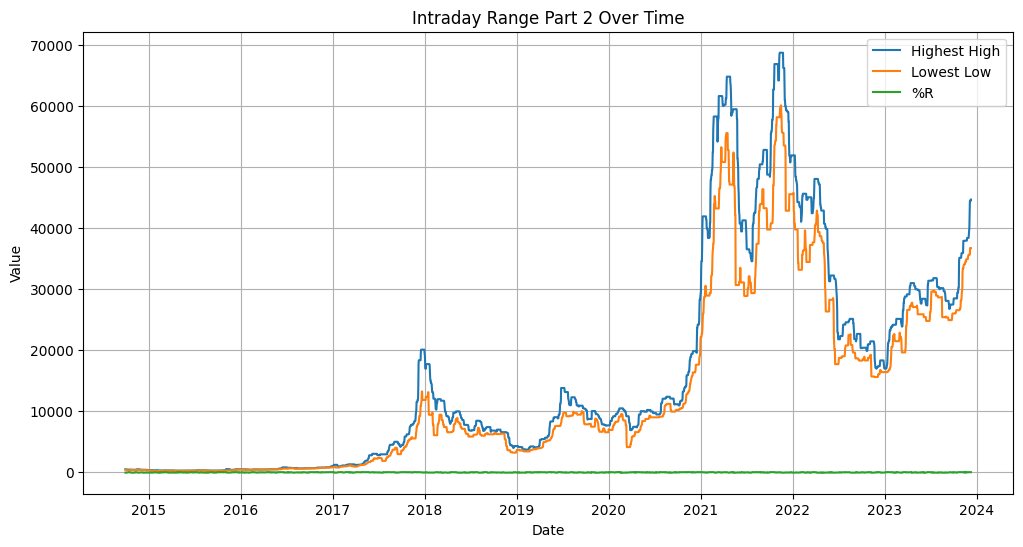

In [ ]:
# Technical Indicator Columns
technical_indicators = ['SMA_14', 'ShortEMA', 'LongEMA', 'MACD', 'RSI', 'RollingMean_14', 'RollingStd_14', 'UpperBand_14', 'LowerBand_14']

# Calculate basic statistics for technical indicator columns
technical_stats = data[technical_indicators].describe()

# Visualize technical indicators
plt.figure(figsize=(12, 6))
for col in technical_indicators:
    plt.plot(data['Date'], data[col], label=col)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Technical Indicators Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Intraday Range Columns
intraday_columns_part1 = ['HL', 'HC', 'LC', 'TR']

# Calculate basic statistics for the first set of intraday range columns
intraday_stats_part1 = data[intraday_columns_part1].describe()

# Visualize the first set of intraday range columns
plt.figure(figsize=(12, 6))
for col in intraday_columns_part1:
    plt.plot(data['Date'], data[col], label=col)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Intraday Range Part 1 Over Time')
plt.legend()
plt.grid(True)
plt.show()

# The second set of intraday range columns
intraday_columns_part2 = ['Highest High', 'Lowest Low', '%R']

# Calculate basic statistics for the second set of intraday range columns
intraday_stats_part2 = data[intraday_columns_part2].describe()

# Visualize the second set of intraday range columns
plt.figure(figsize=(12, 6))
for col in intraday_columns_part2:
    plt.plot(data['Date'], data[col], label=col)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Intraday Range Part 2 Over Time')
plt.legend()
plt.grid(True)
plt.show()

**f. Yearly Bitcoin Price Analysis**

In [ ]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Create a function to plot graphs for a given year
def plot_yearly_graphs(year_data, year):
    # Filtering data for the given year
    yearly_data = year_data.loc[(year_data['Date'] >= f'{year}-01-01') & (year_data['Date'] < f'{year + 1}-01-01')]

    # Group by month and calculate mean
    monthwise = yearly_data.groupby(yearly_data['Date'].dt.strftime('%B'))[['Open', 'Close', 'High', 'Low']].mean()
    new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    monthwise = monthwise.reindex(new_order, axis=0)

    # Plot bar chart for open and close prices
    fig = go.Figure()
    fig.add_trace(go.Bar(x=monthwise.index, y=monthwise['Open'], name='Bitcoin Open Price', marker_color='crimson'))
    fig.add_trace(go.Bar(x=monthwise.index, y=monthwise['Close'], name='Bitcoin Close Price', marker_color='lightsalmon'))
    fig.update_layout(barmode='group', xaxis_tickangle=-45, title=f'Monthwise comparison for {year}')
    fig.show()

    # Plot bar chart for high and low prices
    monthwise_high = yearly_data.groupby(yearly_data['Date'].dt.strftime('%B'))['High'].max()
    monthwise_high = monthwise_high.reindex(new_order, axis=0)

    monthwise_low = yearly_data.groupby(yearly_data['Date'].dt.strftime('%B'))['Low'].min()
    monthwise_low = monthwise_low.reindex(new_order, axis=0)

    fig = go.Figure()
    fig.add_trace(go.Bar(x=monthwise_high.index, y=monthwise_high, name='Bitcoin High Price', marker_color='rgb(0, 153, 204)'))
    fig.add_trace(go.Bar(x=monthwise_low.index, y=monthwise_low, name='Bitcoin Low Price', marker_color='rgb(255, 128, 0)'))
    fig.update_layout(barmode='group', title=f'Monthwise High and Low Bitcoin price for {year}')
    fig.show()

    # Plot line chart for open, close, high, and low prices
    names = cycle(['Bitcoin Open Price', 'Bitcoin Close Price', 'Bitcoin High Price', 'Bitcoin Low Price'])
    fig = px.line(yearly_data, x=yearly_data.Date, y=[yearly_data['Open'], yearly_data['Close'], yearly_data['High'], yearly_data['Low']],
                  labels={'Date': 'Date', 'value': 'Bitcoin value'})
    fig.update_layout(title_text=f'Bitcoin analysis chart for {year}', font_size=15, font_color='black', legend_title_text='Bitcoin Parameters')
    fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

# Iterate over each year
for year in data['Year'].unique():
    plot_yearly_graphs(data, year)


**g. Overall Bitcoin Price Analysis**

In [ ]:
# Filter data for the overall period
overall_data = data.loc[(data['Date'] >= '2014-01-01') & (data['Date'] < '2023-01-01')]

# Group by month and calculate mean
monthwise = overall_data.groupby(overall_data['Date'].dt.strftime('%B'))[['Open', 'Close', 'High', 'Low']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)

# Plot bar chart for open and close prices
fig = go.Figure()
fig.add_trace(go.Bar(x=monthwise.index, y=monthwise['Open'], name='Bitcoin Open Price', marker_color='crimson'))
fig.add_trace(go.Bar(x=monthwise.index, y=monthwise['Close'], name='Bitcoin Close Price', marker_color='lightsalmon'))
fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Monthwise comparison for Overall Analysis')
fig.show()

# Plot bar chart for high and low prices
monthwise_high = overall_data.groupby(overall_data['Date'].dt.strftime('%B'))['High'].max()
monthwise_high = monthwise_high.reindex(new_order, axis=0)

monthwise_low = overall_data.groupby(overall_data['Date'].dt.strftime('%B'))['Low'].min()
monthwise_low = monthwise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(x=monthwise_high.index, y=monthwise_high, name='Bitcoin High Price', marker_color='rgb(0, 153, 204)'))
fig.add_trace(go.Bar(x=monthwise_low.index, y=monthwise_low, name='Bitcoin Low Price', marker_color='rgb(255, 128, 0)'))
fig.update_layout(barmode='group', title='Monthwise High and Low Bitcoin price for Overall Analysis')
fig.show()

# Plot line chart for open, close, high, and low prices
names = cycle(['Bitcoin Open Price', 'Bitcoin Close Price', 'Bitcoin High Price', 'Bitcoin Low Price'])
fig = px.line(overall_data, x=overall_data.Date, y=[overall_data['Open'], overall_data['Close'], overall_data['High'], overall_data['Low']],
              labels={'Date': 'Date', 'value': 'Bitcoin value'})
fig.update_layout(title_text='Bitcoin analysis chart for Overall Analysis', font_size=15, font_color='black', legend_title_text='Bitcoin Parameters')
fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# Drop redundant columns from the DataFrame
data = data.drop(columns=['Date', 'ShortEMA', 'LongEMA', 'RollingMean_14', 'RollingStd_14'])

**h. Correlation Heatmap**

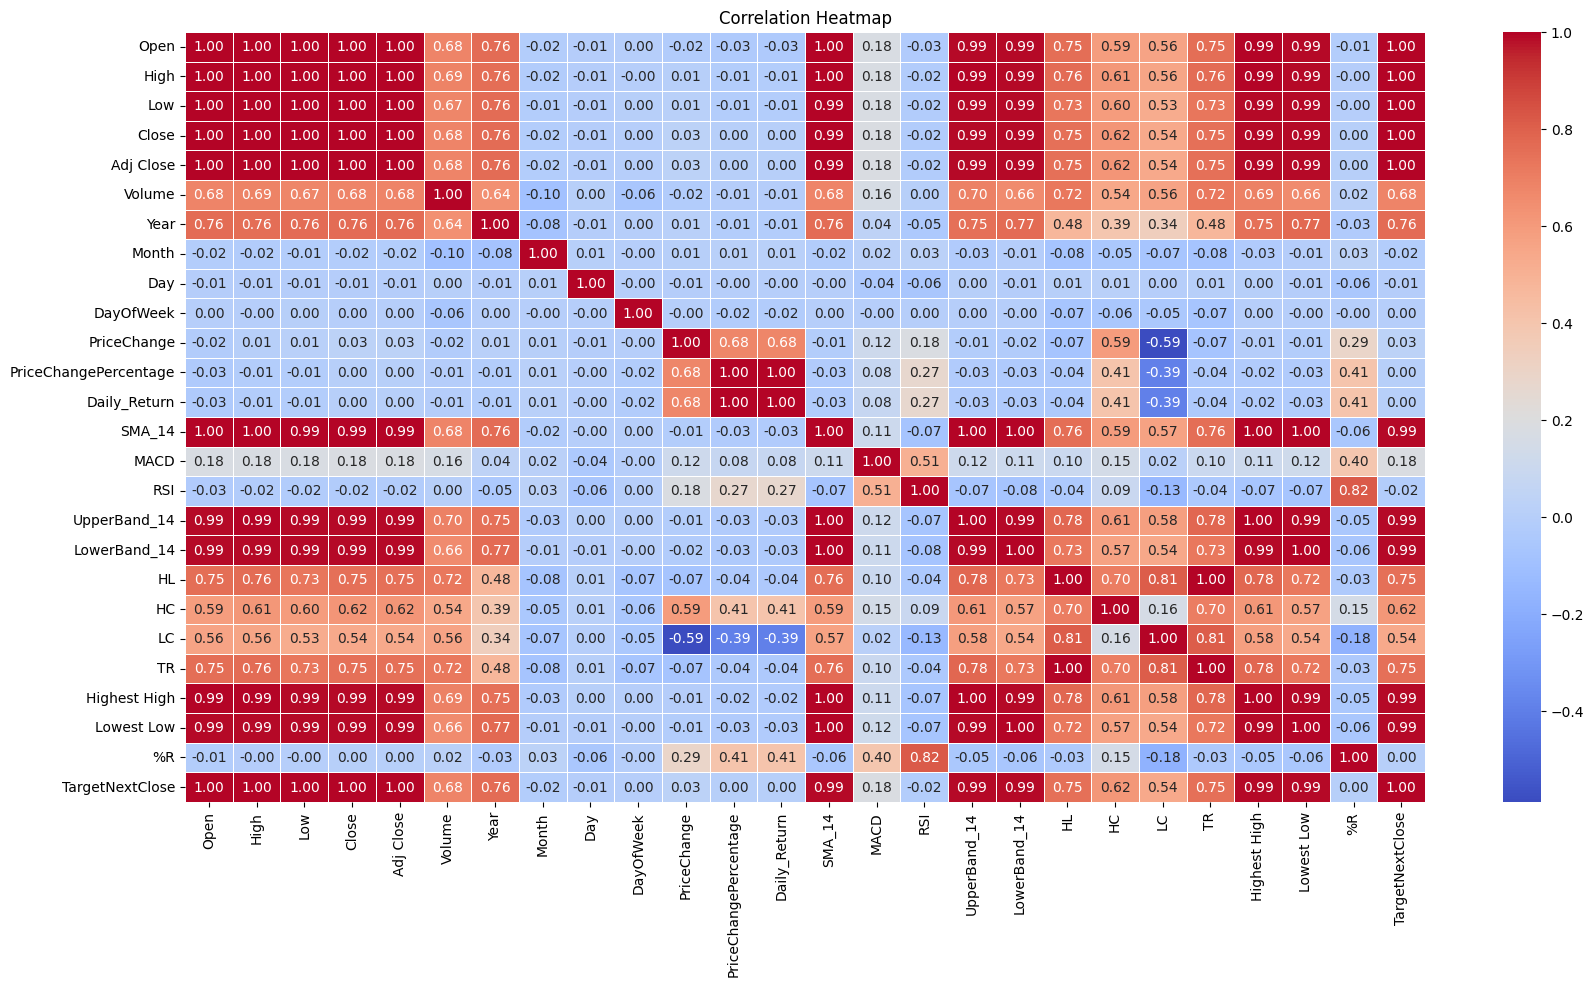

In [ ]:
# Create a correlation matrix
corr = data.corr()

# Plot the Heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## 5. Machine Learning

**Model Evaluation Metrics**:

In model evaluation, various metrics are considered to assess the performance of the model. The following metrics are commonly used:

- **Mean Squared Error (MSE):**
  Formula: MSE = (1/n) * Σ(yᵢ - ȳ)²

- **Root Mean Squared Error (RMSE):**
  Formula: RMSE = √MSE

- **R2 Score:**
  Formula: R² = 1 - Σ(yᵢ - ȳ)² / Σ(yᵢ - ȳ̅)²

- **Mean Absolute Error (MAE):**
  Formula: MAE = (1/n) * Σ|yᵢ - ȳ|

- **Mean Absolute Percentage Error (MAPE):**
  Formula: MAPE = (1/n) * Σ(|yᵢ - ȳ| / |yᵢ|) * 100



In [ ]:
# Check the data types of each column to ensure validity before using them for machine learning
data.dtypes

Open                     float64
High                     float64
Low                      float64
Close                    float64
Adj Close                float64
Volume                     int64
Year                       int64
Month                      int64
Day                        int64
DayOfWeek                  int64
PriceChange              float64
PriceChangePercentage    float64
Daily_Return             float64
SMA_14                   float64
MACD                     float64
RSI                      float64
UpperBand_14             float64
LowerBand_14             float64
HL                       float64
HC                       float64
LC                       float64
TR                       float64
Highest High             float64
Lowest Low               float64
%R                       float64
TargetNextClose          float64
dtype: object

**I. XGBoost Regression**:
 - XGBoost, an advanced gradient boosting algorithm, stands out as an optimal choice for predicting Adj Close prices in financial markets.
 - Its ability to capture non-linear patterns, handle regularization, provide feature importance insights, and efficiently scale to large datasets makes it well-suited for the complexities of stock price prediction.
 - Additionally, XGBoost's robustness to outliers and effective handling of missing data contribute to its reliability in financial modeling, offering a versatile and high-performance solution for predicting the closing prices of assets.
 - In XGBoost regression for predicting Adj Close prices, historical stock data such as open, high, low prices, volume, and technical indicators serve as features, while the target variable is the corresponding 'TargetNextClose' price.

**a. Split Data into Train, Validation, and Test Sets**

In [ ]:
# Define features (X) and target (y)
X, y = data.drop(columns=['TargetNextClose']), data['TargetNextClose']

# Calculate the lengths for training (80%), validation (10%), and test (10%) sets
train_len = int(0.8 * len(data))
val_len = int(0.1 * len(data))
test_len = len(data) - train_len - val_len

# Split the features (X) and target variable (y) into training, validation, and test sets
X_train_1, y_train_1 = X[:train_len], y[:train_len]
X_val_1, y_val_1 = X[train_len:train_len + val_len], y[train_len:train_len + val_len]
X_test_1, y_test_1 = X[train_len + val_len:], y[train_len + val_len:]

# Print the shapes
print("X_train_1 shape:", X_train_1.shape)
print("y_train_1 shape:", y_train_1.shape)
print("X_val_1 shape:", X_val_1.shape)
print("y_val_1 shape:", y_val_1.shape)
print("X_test_1 shape:", X_test_1.shape)
print("y_test_1 shape:", y_test_1.shape)

X_train_1 shape: (2686, 25)
y_train_1 shape: (2686,)
X_val_1 shape: (335, 25)
y_val_1 shape: (335,)
X_test_1 shape: (337, 25)
y_test_1 shape: (337,)


**b. Principal Component Analysis (PCA):**
  - PCA is often used before applying XGBoost to reduce the dimensionality of the feature space.
  - By transforming the original features into a smaller set of uncorrelated variables (principal components), PCA helps capture the most important information while discarding redundant or less significant features
  - This can enhance the performance of XGBoost by focusing on relevant information, improving computational efficiency, and potentially mitigating issues related to multicollinearity.

In [ ]:
# Standardize the training and validation data using StandardScaler (important for PCA)
scaler = StandardScaler()
X_train_temp = scaler.fit_transform(X_train_1)
X_val_temp = scaler.fit_transform(X_val_1)

# Perform PCA with a higher number of components initially (for elbow plot)
n_components = 20
pca_temp = PCA(n_components=n_components)

# Transform the standardized data using PCA
X_pca_train_temp = pca_temp.fit_transform(X_train_temp)

# Explained variance ratio
explained_variance = pca_temp.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
print("Explained Variance Ratio:", explained_variance)
print("cumulative explained variance:", cumulative_explained_variance)

Explained Variance Ratio: [5.38930488e-01 1.38791750e-01 6.89044381e-02 4.51661286e-02
 4.10710147e-02 3.95073975e-02 3.57180604e-02 3.09969879e-02
 2.23874636e-02 2.13498057e-02 6.61178419e-03 6.56764582e-03
 3.15830964e-03 5.04269204e-04 2.59451653e-04 3.66347926e-05
 1.98299185e-05 1.81925314e-05 3.43714419e-07 3.97794258e-09]
cumulative explained variance: [0.53893049 0.67772224 0.74662668 0.7917928  0.83286382 0.87237122
 0.90808928 0.93908627 0.96147373 0.98282353 0.98943532 0.99600296
 0.99916127 0.99966554 0.999925   0.99996163 0.99998146 0.99999965
 1.         1.        ]


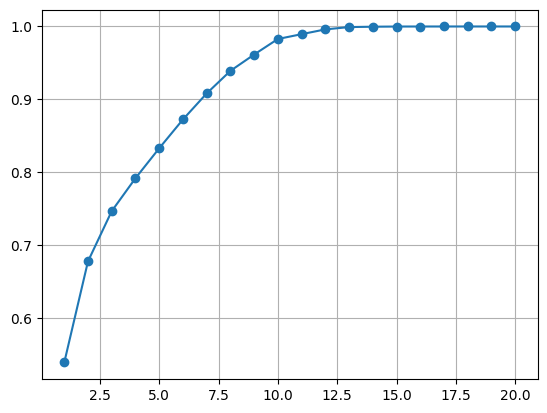

In [ ]:
# Plot cumulative explained variance for each number of components
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.grid(True)
plt.show()

Note: The optimal number of components (10 components) for PCA was chosen based on the elbow plot, which indicates the cumulative explained variance.

In [ ]:
# Perform PCA with 10 components on training, validation, and test sets
n_components = 10
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_1)
X_val_pca = pca.transform(X_val_1)
X_test_pca = pca.transform(X_test_1)

# Display the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
print("Explained Variance Ratio:", explained_variance)
print("cumulative explained variance:", cumulative_explained_variance)

Explained Variance Ratio: [1.00000000e+00 2.95171172e-12 1.69470228e-14 1.04678894e-14
 3.58242333e-15 2.00815444e-15 1.86079113e-15 5.22603243e-16
 3.50127590e-16 2.43715287e-16]
cumulative explained variance: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Print the shapes
print("X_train_pca shape:", X_train_pca.shape)
print("y_train_1 shape:", y_train_1.shape)
print("X_val_pca shape:", X_val_pca.shape)
print("y_val_1 shape:", y_val_1.shape)
print("X_test_pca shape:", X_test_pca.shape)
print("y_test_1 shape:", y_test_1.shape)

X_train_pca shape: (2686, 10)
y_train_1 shape: (2686,)
X_val_pca shape: (335, 10)
y_val_1 shape: (335,)
X_test_pca shape: (337, 10)
y_test_1 shape: (337,)


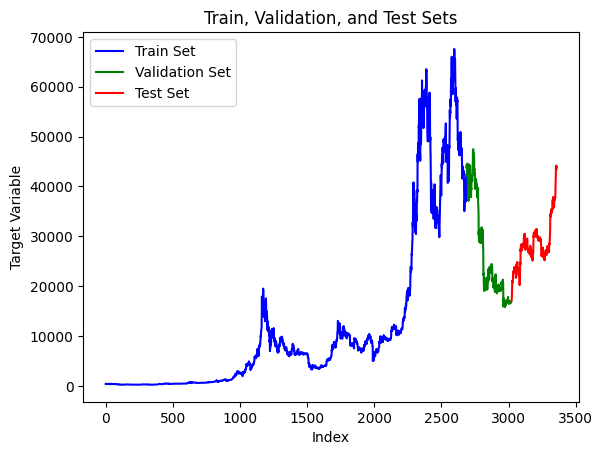

In [ ]:
# Set Indices for Train, Validation, and Test Sets
train_indices = np.arange(len(X_train_1))
val_indices = np.arange(len(X_train_1), len(X_train_1) + len(X_val_1))
test_indices = np.arange(len(X_train_1) + len(X_val_1), len(X_train_1) + len(X_val_1) + len(X_test_1))

# Plot the Sets
plt.plot(train_indices, y_train_1, color='blue', label='Train Set')
plt.plot(val_indices, y_val_1, color='green', label='Validation Set')
plt.plot(test_indices, y_test_1, color='red', label='Test Set')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.title('Train, Validation, and Test Sets')
plt.legend()
plt.show()

**c. Hyperparameter Tuning with RandomizedSearchCV for XGBoost**

In [ ]:
# Define hyperparameters for random search
param_dist = {
    'n_estimators': [80, 90, 100, 110, 120],
    'max_depth': [2, 3, 4],
    'learning_rate': np.linspace(0.2, 0.6, 20),
    'subsample': np.linspace(0.8, 1.0, 20),
    'min_child_weight': [2, 3, 4],
    'gamma': np.linspace(0.1, 0.3, 20),
    'colsample_bytree': np.linspace(0.6, 0.8, 20),
    'reg_alpha': np.linspace(0.01, 0.03, 20),
    'reg_lambda': np.linspace(0.02, 0.04, 20),
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    cv=20,
    n_iter=1500,
    random_state=42,
    verbose = 3
)

# Fit the model with the best hyperparameters
random_search.fit(X_train_pca, y_train_1)

Streaming output truncated to the last 5000 lines.
[CV 1/20] END colsample_bytree=0.7263157894736842, gamma=0.2368421052631579, learning_rate=0.45263157894736844, max_depth=4, min_child_weight=4, n_estimators=120, reg_alpha=0.025789473684210522, reg_lambda=0.024210526315789474, subsample=0.968421052631579;, score=-12100.747 total time=   0.1s
[CV 2/20] END colsample_bytree=0.7263157894736842, gamma=0.2368421052631579, learning_rate=0.45263157894736844, max_depth=4, min_child_weight=4, n_estimators=120, reg_alpha=0.025789473684210522, reg_lambda=0.024210526315789474, subsample=0.968421052631579;, score=-1298.766 total time=   0.1s
[CV 3/20] END colsample_bytree=0.7263157894736842, gamma=0.2368421052631579, learning_rate=0.45263157894736844, max_depth=4, min_child_weight=4, n_estimators=120, reg_alpha=0.025789473684210522, reg_lambda=0.024210526315789474, subsample=0.968421052631579;, score=-1810.129 total time=   0.1s
[CV 4/20] END colsample_bytree=0.7263157894736842, gamma=0.2368421052

RandomizedSearchCV(cv=20,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
       0.03052632, 0.03157895, 0.03263158, 0.03368421, 0.03473684,
       0.03578947, 0.03684211, 0.03789474, 0.03894737, 0.04      ]),
                                        'subsample': array([0.8       , 0.81052632, 0.82105263, 0.83157895, 0.84210526,
       0.85263158, 0.86315789, 0.87368421, 0.88421053, 0.89473684,
       0.90526316, 0.91578947, 0.92631579, 0.93684211, 0.94736842,
       0.95789474, 0.96842105, 0.97894737, 0.98947368, 1.        ])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=3)

In [ ]:
# Get the best model
best_model = random_search.best_estimator_

# Get the best parameters
Xgb_best_params = random_search.best_params_
print(f'Best Hyperparameters: {Xgb_best_params}')

Best Hyperparameters: {'subsample': 0.968421052631579, 'reg_lambda': 0.02526315789473684, 'reg_alpha': 0.028947368421052624, 'n_estimators': 120, 'min_child_weight': 2, 'max_depth': 2, 'learning_rate': 0.4736842105263158, 'gamma': 0.1105263157894737, 'colsample_bytree': 0.6421052631578947}


**d. Model Evaluation on training data**

In [ ]:
# Make predictions on the training set
y_train_pred_xgb = best_model.predict(X_train_pca)

# Evaluate the model on the training set
mse_train_xgb = mean_squared_error(y_train_1, y_train_pred_xgb)
print(f'Mean Squared Error on Training Set: {mse_train_xgb}')

# Calculate RMSE for the training set
rmse_train_xgb = np.sqrt(mean_squared_error(y_train_1, y_train_pred_xgb))
print(f'RMSE on Training Set: {rmse_train_xgb}')

# Calculate R2 score for the training set
r2_train_xgb = r2_score(y_train_1, y_train_pred_xgb)
print(f'R2 Score on Training Set: {r2_train_xgb}')

# Calculate MAE for the training set
mae_train_xgb = mean_absolute_error(y_train_1, y_train_pred_xgb)
print(f'Mean Absolute Error on Training Set: {mae_train_xgb}')

# Calculate MAPE for the training set
mape_train_xgb = np.mean(np.abs((y_train_1 - y_train_pred_xgb) / y_train_1)) * 100
print(f'Mean Absolute Percentage Error on Training Set: {mape_train_xgb:.4f}%')

Mean Squared Error on Training Set: 984574.1861776338
RMSE on Training Set: 992.2571169700088
R2 Score on Training Set: 0.9961639441668437
Mean Absolute Error on Training Set: 607.5995529186166
Mean Absolute Percentage Error on Training Set: 12.8091%


**e. Model Evaluation on Validation Set**

In [ ]:
# Make predictions on the validation set
y_val_pred_xgb = best_model.predict(X_val_pca)

# Evaluate the model on the validation set
mse_val_xgb = mean_squared_error(y_val_1, y_val_pred_xgb)
print(f'Mean Squared Error on Validation Set: {mse_val_xgb}')

# Calculate RMSE for the validation set
rmse_val_xgb = np.sqrt(mean_squared_error(y_val_1, y_val_pred_xgb))
print(f'RMSE on Validation Set: {rmse_val_xgb}')

# Calculate R2 score for the validation set
r2_val_xgb = r2_score(y_val_1, y_val_pred_xgb)
print(f'R2 Score on Validation Set: {r2_val_xgb}')

# Calculate MAE for the validation set
mae_val_xgb = mean_absolute_error(y_val_1, y_val_pred_xgb)
print(f'Mean Absolute Error on Validation Set: {mae_val_xgb}')

# Calculate MAPE for the validation set
mape_val_xgb = np.mean(np.abs((y_val_1 - y_val_pred_xgb) / y_val_1)) * 100
print(f'Mean Absolute Percentage Error on Validation Set: {mape_val_xgb:.4f}%')

Mean Squared Error on Validation Set: 15346403.404506695
RMSE on Validation Set: 3917.4485835179375
R2 Score on Validation Set: 0.8368242893586952
Mean Absolute Error on Validation Set: 3067.705967234142
Mean Absolute Percentage Error on Validation Set: 12.8127%


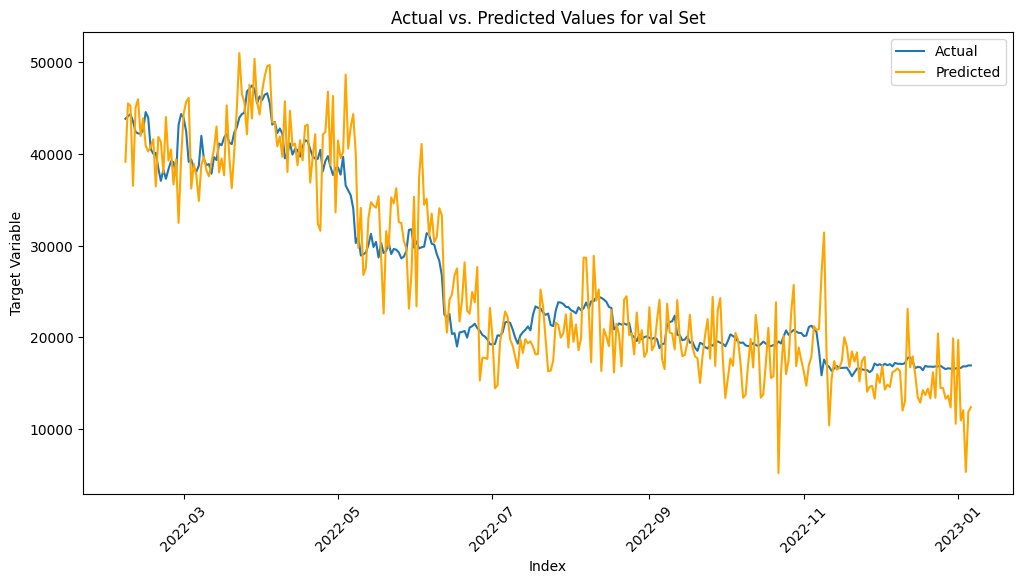

In [ ]:
# Plot actual vs. predicted values for the val set
plt.figure(figsize=(12, 6))
plt.plot(y_val_1.index, y_val_1, label='Actual')
plt.plot(y_val_1.index, y_val_pred_xgb, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.legend()
plt.title('Actual vs. Predicted Values for val Set')
plt.xticks(rotation=45)
plt.show()

**II. Long Short-Term Memory(LSTM)**:

 - LSTM is a type of recurrent neural network (RNN) that is well-suited for time series data, such as Bitcoin prices, due to its ability to capture long-term dependencies and patterns in sequential data.
 - LSTM can effectively model complex relationships and dependencies over time, making it suitable for predicting the volatile and dynamic nature of cryptocurrency prices.
 - Compared to traditional machine learning algorithms like XGBoost, LSTM can inherently handle sequential information and temporal dependencies, making it more adept at capturing patterns in time series data.
 - LSTM is a robust choice for Bitcoin price prediction due to its inherent capabilities in handling sequential and time-dependent data.
 - In LSTM for Bitcoin price prediction, historical price and volume data, along with relevant technical indicators, are utilized as features, while the target variable is the 'TargetNextClose' price (GeeksforGeeks, 2023).

**a. Normalize Data and Prepare Input Sequences for LSTM**

In [ ]:
# Normalize the 'data' DataFrame using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = scaler.fit_transform(data)

# Initialize empty lists for features (X) and target variable (y)
X = []
timesteps = 14

# Create input sequences for LSTM
for j in range(data.shape[1]):
    X.append([])
    for i in range(timesteps, data_set_scaled.shape[0]):
        # Append sequences of length 'timesteps' for each feature
        X[j].append(data_set_scaled[i - timesteps:i, j])

# Move axis from 0 to position 2 for compatibility with LSTM input
X = np.moveaxis(X, [0], [2])

# Convert lists to NumPy arrays
X, yi = np.array(X), np.array(data_set_scaled[timesteps:, -1])
y = np.reshape(yi, (len(yi), 1))

In [ ]:
# Print the shapes of X and y
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (3344, 14, 26)
Shape of y: (3344, 1)


**b. Split Data into Train, Validation, and Test Sets**

In [ ]:
# Calculate the lengths for training (80%), validation (10%), and test (10%) sets
train_len = int(0.8 * len(data))
val_len = int(0.1 * len(data))
test_len = len(data) - train_len - val_len

# Split the features (X) and target variable (y) into training, validation, and test sets
X_train_2, y_train_2 = X[:train_len], y[:train_len]
X_val_2, y_val_2 = X[train_len:train_len + val_len], y[train_len:train_len + val_len]
X_test_2, y_test_2 = X[train_len + val_len:], y[train_len + val_len:]

# Print the shapes
print("X_train_2 shape:", X_train_2.shape)
print("y_train_2 shape:", y_train_2.shape)
print("X_val_2 shape:", X_val_2.shape)
print("y_val_2 shape:", y_val_2.shape)
print("X_test_2 shape:", X_test_2.shape)
print("y_test_2 shape:", y_test_2.shape)

X_train_2 shape: (2686, 14, 26)
y_train_2 shape: (2686, 1)
X_val_2 shape: (335, 14, 26)
y_val_2 shape: (335, 1)
X_test_2 shape: (323, 14, 26)
y_test_2 shape: (323, 1)


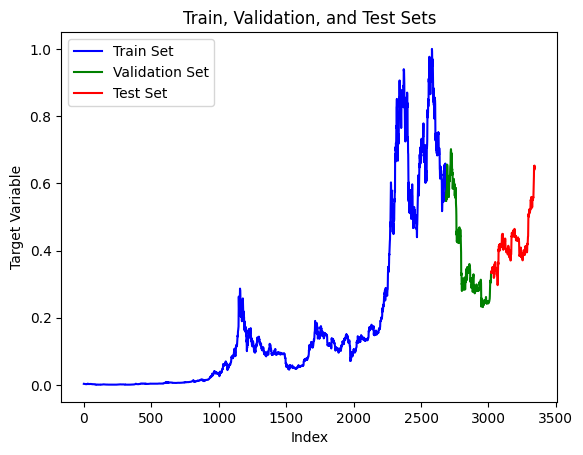

In [ ]:
# Set Indices for Train, Validation, and Test Sets
train_indices = np.arange(len(X_train_2))
val_indices = np.arange(len(X_train_2), len(X_train_2) + len(X_val_2))
test_indices = np.arange(len(X_train_2) + len(X_val_2), len(X_train_2) + len(X_val_2) + len(X_test_2))

# Plot the Sets
plt.plot(train_indices, y_train_2, color='blue', label='Train Set')
plt.plot(val_indices, y_val_2, color='green', label='Validation Set')
plt.plot(test_indices, y_test_2, color='red', label='Test Set')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.title('Train, Validation, and Test Sets')
plt.legend()
plt.show()

**c. Build and Train LSTM Model**

In [ ]:
# Create a Sequential model
model = Sequential()

# Add LSTM layers with dropou
model.add(LSTM(150, return_sequences=True, input_shape=(timesteps, 26), name='first_layer'))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True, input_shape=(timesteps, 26), name='second_layer'))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, 26), name='third_layer'))
model.add(Dropout(0.2))

# Add a Dense layer with linear activation
model.add(Dense(1, name='dense_layer'))
model.add(Activation('linear', name='output'))

# Compile the model using the Adam optimizer and mean squared error loss
adam_optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer, loss='mse')

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode = 'min', verbose=1, save_best_only=True)

# Train the model using training data
history = model.fit(x=X_train_2, y=y_train_2, batch_size=32, epochs=300, validation_split=0.1, callbacks=[early_stopping, checkpoint])

Epoch 1/300
75/76 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 1: val_loss improved from inf to 0.03748, saving model to best_model.h5
76/76 [==============================] - 15s 75ms/step - loss: 0.0085 - val_loss: 0.0375
Epoch 2/300
 3/76 [>.............................] - ETA: 3s - loss: 0.0039

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



75/76 [============================>.] - ETA: 0s - loss: 0.0033
Epoch 2: val_loss improved from 0.03748 to 0.01580, saving model to best_model.h5
76/76 [==============================] - 7s 98ms/step - loss: 0.0033 - val_loss: 0.0158
Epoch 3/300
75/76 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 3: val_loss improved from 0.01580 to 0.00889, saving model to best_model.h5
76/76 [==============================] - 4s 57ms/step - loss: 0.0019 - val_loss: 0.0089
Epoch 4/300
75/76 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 4: val_loss improved from 0.00889 to 0.00514, saving model to best_model.h5
76/76 [==============================] - 4s 59ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 5/300
75/76 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 5: val_loss did not improve from 0.00514
76/76 [==============================] - 6s 82ms/step - loss: 0.0014 - val_loss: 0.0151
Epoch 6/300
76/76 [==============================] - ETA: 0s - 

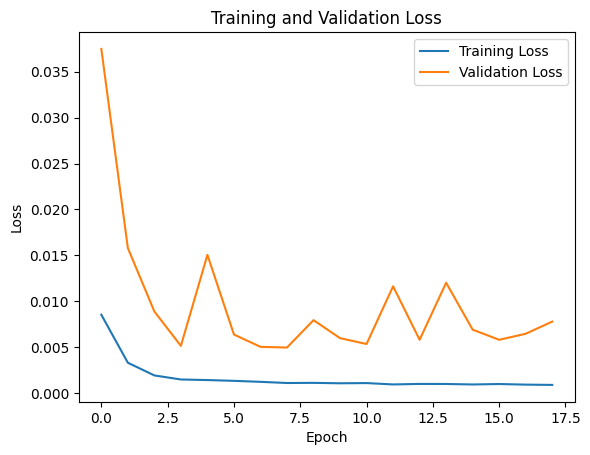

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Load the best model
best_model = load_model('best_model.h5')
best_model

**d. Model Evaluation on training data**

In [ ]:
# Make predictions on the training set
y_pred_train = best_model.predict(X_train_2)

# Extract the last prediction for each sequence
y_pred_train_last = y_pred_train[:, -1, :]

# Calculate R^2 for training set
r2_train = r2_score(y_train_2, y_pred_train_last)

# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train_2, y_pred_train_last)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Error (MAE) for training set
mae_train = mean_absolute_error(y_train_2, y_pred_train_last)

# Calculate Mean Absolute Percentage Error (MAPE) for training set
mape_train = np.mean(np.abs((y_train_2 - y_pred_train_last) / y_train_2)) * 100

# Print the results for training set
print("R^2 Score (Training Set):", r2_train)
print("Mean Squared Error (MSE) (Training Set):", mse_train)
print("Root Mean Squared Error (RMSE) (Training Set):", rmse_train)
print("Mean Absolute Error (MAE) (Training Set):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Training Set):", mape_train)

84/84 [==============================] - 2s 19ms/step
R^2 Score (Training Set): 0.9876734776399028
Mean Squared Error (MSE) (Training Set): 0.0007086265107943059
Root Mean Squared Error (RMSE) (Training Set): 0.02662003964674557
Mean Absolute Error (MAE) (Training Set): 0.02153542164259979
Mean Absolute Percentage Error (MAPE) (Training Set): inf


<ipython-input-65-fec75acd40cd>:20: RuntimeWarning:

divide by zero encountered in divide



**e. Model Evaluation on Validation Set**

In [ ]:
# Make predictions on the validation set
y_pred_val = best_model.predict(X_val_2)

# Extract the last prediction for each sequence
y_pred_val_last = y_pred_val[:, -1, :]

# Calculate R^2 for validation set
r2_val = r2_score(y_val_2, y_pred_val_last)

# Calculate Mean Squared Error (MSE) for validation set
mse_val = mean_squared_error(y_val_2, y_pred_val_last)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_val = np.sqrt(mse_val)

# Calculate Mean Absolute Error (MAE) for validation set
mae_val = mean_absolute_error(y_val_2, y_pred_val_last)

# Calculate Mean Absolute Percentage Error (MAPE) for validation set
mape_val = np.mean(np.abs((y_val_2 - y_pred_val_last) / y_val_2)) * 100

# Print the results for validation set
print("R^2 Score (Validation Set):", r2_val)
print("Mean Squared Error (MSE) (Validation Set):", mse_val)
print("Root Mean Squared Error (RMSE) (Validation Set):", rmse_val)
print("Mean Absolute Error (MAE) (Validation Set):", mae_val)
print("Mean Absolute Percentage Error (MAPE) (Validation Set):", mape_val)

11/11 [==============================] - 0s 17ms/step
R^2 Score (Validation Set): 0.973331795717005
Mean Squared Error (MSE) (Validation Set): 0.0004965515233341147
Root Mean Squared Error (RMSE) (Validation Set): 0.022283436075572247
Mean Absolute Error (MAE) (Validation Set): 0.01658509377572085
Mean Absolute Percentage Error (MAPE) (Validation Set): 4.486444808924489


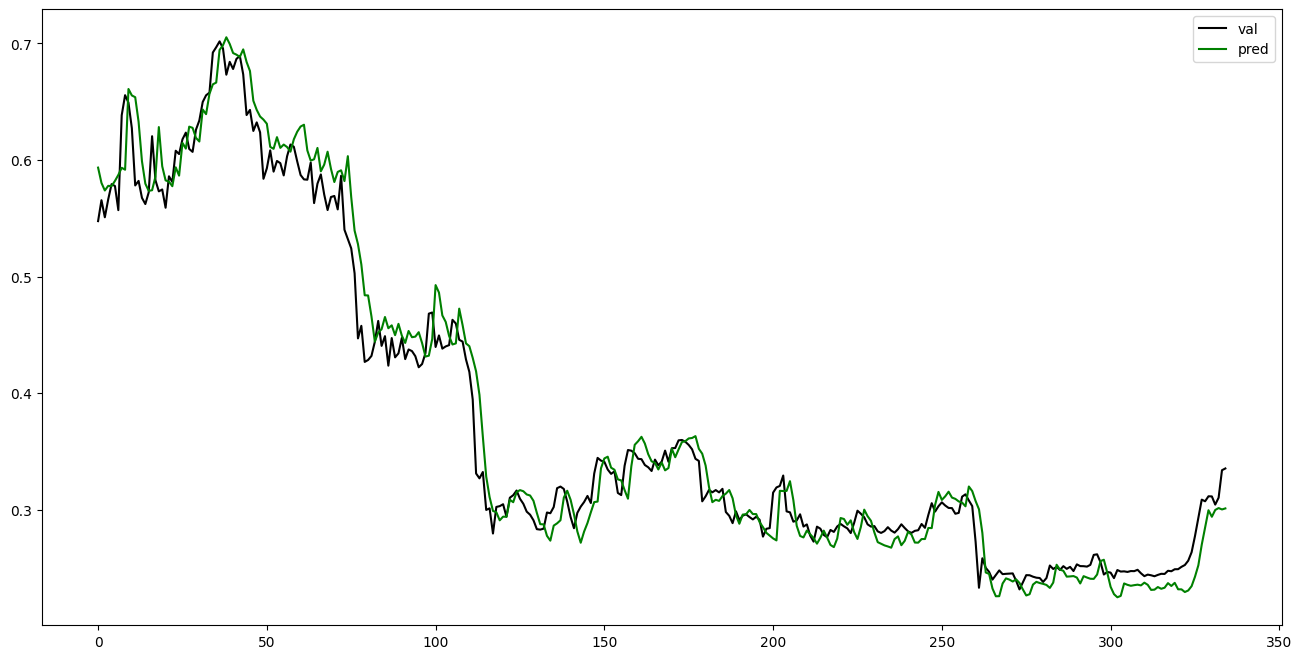

In [ ]:
# Plot actual vs. predicted values for the validation set
plt.figure(figsize=(16,8))
plt.plot(y_val_2, color = 'black', label = 'val')
plt.plot(y_pred_val_last, color = 'green', label = 'pred')
plt.legend()
plt.show()

**III. Auto Regressive Integrated Moving Average (ARIMA)**:
 - ARIMA is preferred for Bitcoin forecasting due to its ability to handle seasonality, statistical rigor, simplicity, and interpretability.
 - It is effective in dealing with non-stationary data and offers robust forecasting for short to medium-term predictions.
 - ARIMA's historical dependency modeling and adaptability make it valuable for traders and investors.
 - ARIMA is univariate, utilizing only historical Bitcoin prices as input features to forecast future prices as the target variable.

**a. Checking Autocorrelation for Time Series Analysis**

<Figure size 1200x600 with 0 Axes>

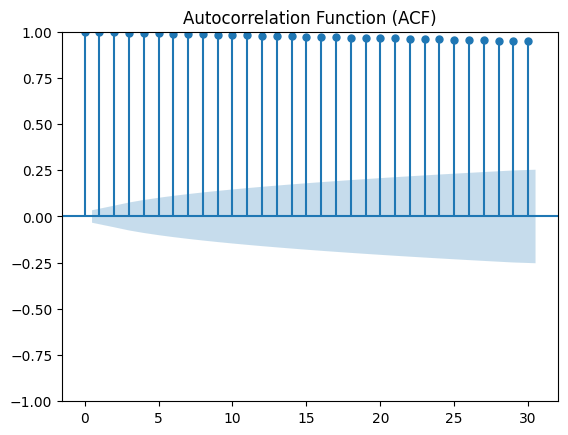

In [ ]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(data['TargetNextClose'], lags=30, title='Autocorrelation Function (ACF)')
plt.show()

The ACF shows a strong, positive correlation that persists across several time lags, indicating a potential non-stationary time series, which is typical for financial data like Bitcoin prices.


**b. Checking Partial Autocorrelation for Time Series Analysis**

<Figure size 1200x600 with 0 Axes>

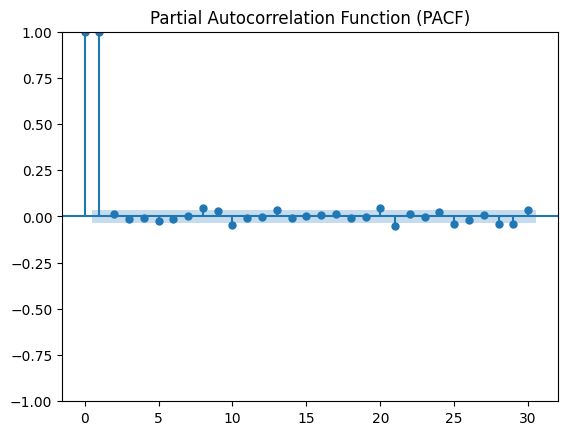

In [ ]:
# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(data['TargetNextClose'], lags=30, title='Partial Autocorrelation Function (PACF)')
plt.show()

The PACF indicates a significant correlation at the first lag and no significant correlations afterward.

**c. Split Data into Train, Validation, and Test Sets**

In [ ]:
# Split into train and test sets
X = data['TargetNextClose'].values
size = int(len(X) * 0.8)

# Split first 80% for training
X_train_3 = X[:size]

# Split next 10% (80-90%) for validation
validation_size = int(size + 0.1 * len(X))
X_val_3 = X[size:validation_size]

# Split last 10% (90-100%) for testing
X_test_3 = X[validation_size:]

# Initialize a list to store prediction history
history = [x for x in X_train_3]

**d. Walk-forward validation using ARIMA model**:
In walk-forward prediction, the model is trained on historical data up to a certain point, and then predictions are made one step at a time, with each new prediction updating the model.

 - After experimenting with different p, q, d values (2, 1, 0; 0, 1, 18), we identified 5, 1, 0 as the optimal combination
 - The ARIMA(5,1,0) model is trained on the historical data ('history') up to the current step in the validation set. The model forecasts the next value, and the process is repeated for each step in the validation set.
 - This walk-forward validation helps assess the model's performance on unseen data, iteratively refining predictions as new information becomes available.
 - This analysis draws inspiration from the following link: [ARIMA for Time Series Forecasting with Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)  (Brownlee, 2023).

Walk-forward Validation for ARIMA Model on Validation Data


In [ ]:
# Walk-forward validation using ARIMA model for validation data

val_pred = list()
for t in range(len(X_val_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    val_pred.append(yhat)

    # Update the history with the observed value
    obs = X_val_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=42393.659449, Expected=43840.285156
Predicted=44025.634878, Expected=44118.445312
Predicted=44223.733774, Expected=44338.796875
Predicted=44400.438080, Expected=43565.113281
Predicted=43683.074877, Expected=42407.937500
Predicted=42484.804726, Expected=42244.468750
Predicted=42253.874331, Expected=42197.515625
Predicted=42151.202385, Expected=42586.917969
Predicted=42501.767612, Expected=44575.203125
Predicted=44493.597431, Expected=43961.859375
Predicted=43979.348160, Expected=40538.011719
Predicted=40662.429999, Expected=40030.976562
Predicted=40146.502331, Expected=40122.156250
Predicted=40100.862551, Expected=38431.378906
Predicted=38288.562032, Expected=37075.281250
Predicted=37014.214794, Expected=38286.027344
Predicted=38234.092744, Expected=37296.570312
Predicted=37213.943142, Expected=38332.609375
Predicted=38230.573700, Expected=39214.218750
Predicted=39210.707484, Expected=39105.148438
Predicted=39095.307295, Expected=37709.785156
Predicted=37789.242774, Expected=4

**e. Model Evaluation on Validation Set**

In [ ]:
# Convert validation and predictions to DataFrames for plotting
val_df = DataFrame(X_val_3, index=data['TargetNextClose'].index[size:validation_size], columns=['Actual'])
val_pred_df = DataFrame(val_pred, index=data['TargetNextClose'].index[size:validation_size], columns=['Predicted'])

# Evaluate forecasts for validation data
mse_val = mean_squared_error(val_df, val_pred_df)
rmse_val = np.sqrt(mse_val)

# Calculate R-squared (R^2) score for validation data
r2_val = r2_score(val_df, val_pred_df)

# Calculate Mean Absolute Error (MAE) for validation data
mae_val = mean_absolute_error(val_df, val_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for validation data
mape_val = np.mean(np.abs((np.array(val_df) - np.array(val_pred_df)) / np.array(val_df))) * 100

# Print results for validation data
print(f'Mean Squared Error (MSE) for Validation Data: {mse_val:.3f}')
print(f'Root Mean Squared Error (RMSE) for Validation Data: {rmse_val:.3f}')
print(f'R-squared (R^2) Score for Validation Data: {r2_val:.3f}')
print(f'Mean Absolute Error (MAE) for Validation Data: {mae_val:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Validation Data: {mape_val:.3f}%')

Mean Squared Error (MSE) for Validation Data: 939940.724
Root Mean Squared Error (RMSE) for Validation Data: 969.505
R-squared (R^2) Score for Validation Data: 0.990
Mean Absolute Error (MAE) for Validation Data: 621.933
Mean Absolute Percentage Error (MAPE) for Validation Data: 2.258%


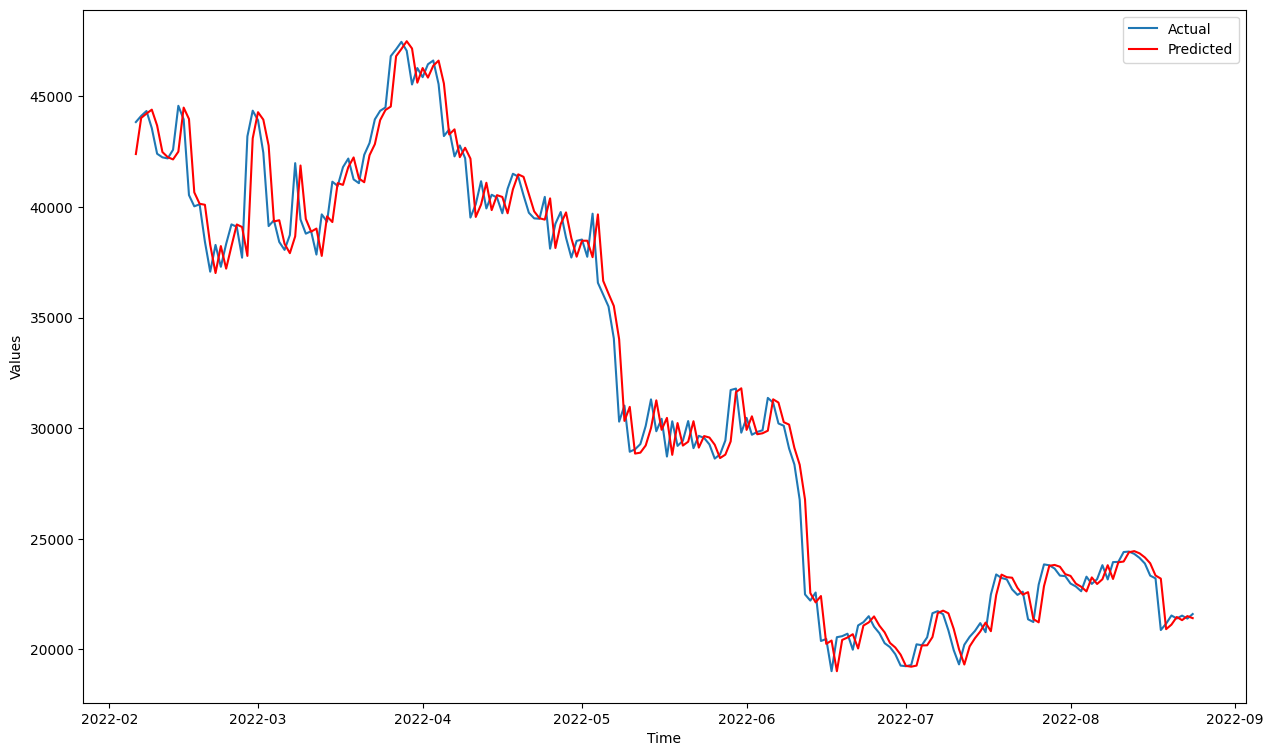

In [ ]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values = val_df['Actual'].iloc[start_index:end_index]
predicted_values = val_pred_df['Predicted'].iloc[start_index:end_index]
time_index = val_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index, actual_values, label='Actual')

# Plot predicted values in red
plt.plot(time_index, predicted_values, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

## 6. Model Evaluation:

Here's a table summarizing the evaluation metrics for XGBoost, LSTM, and ARIMA models on the validation set:

| Metric                               | XGBoost | LSTM   | ARIMA |
|--------------------------------------|---------|--------|-------|
| R-squared (R^2) Score                 | 0.8368  | 0.9733 | 0.990 |
| Mean Absolute Percentage Error (MAPE) | 12.8127% | 4.4864% | 2.258% |



**Reasons for Choosing ARIMA:**

 - Considering the comprehensive evaluation metrics, ARIMA emerges as the preferred model for this particular validation set. Its superior performance in terms of R-squared and MAPE suggests that ARIMA provides more accurate and reliable predictions compared to XGBoost and LSTM for the given data.

 - **Statistical Model:** ARIMA is a statistical time series model, and its strong performance on this dataset suggests that it captures the underlying patterns and trends effectively.

In summary, based on the evaluation metrics, ARIMA outperforms XGBoost and LSTM on the validation set, demonstrating higher accuracy and a better fit to the given time series data.









##7. Pridiction on testing Data

In [ ]:
# Walk-forward validation using ARIMA model for testing data

test_pred = list()
for t in range(len(X_test_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    test_pred.append(yhat)

    # Update the history with the observed value
    obs = X_test_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=16960.688585, Expected=17091.144531
Predicted=17091.537371, Expected=17196.554688
Predicted=17197.642632, Expected=17446.292969
Predicted=17444.413693, Expected=17934.896484
Predicted=17929.329757, Expected=18869.587891
Predicted=18857.128983, Expected=19909.574219
Predicted=19905.727734, Expected=20976.298828
Predicted=20992.053126, Expected=20880.798828
Predicted=20945.680927, Expected=21169.632812
Predicted=21230.096466, Expected=21161.519531
Predicted=21211.138256, Expected=20688.781250
Predicted=20718.566386, Expected=21086.792969
Predicted=21082.179662, Expected=22676.552734
Predicted=22633.406511, Expected=22777.625000
Predicted=22774.494471, Expected=22720.416016
Predicted=22759.046809, Expected=22934.431641
Predicted=22988.070906, Expected=22636.468750
Predicted=22669.935699, Expected=23117.859375
Predicted=23108.350309, Expected=23032.777344
Predicted=23037.275621, Expected=23078.728516
Predicted=23080.175118, Expected=23031.089844
Predicted=23041.875452, Expected=2

**a. Model Evaluation on testing Set**

In [ ]:
# Convert test and predictions to DataFrames for plotting
test_df = DataFrame(X_test_3, index=data['TargetNextClose'].index[validation_size:], columns=['Actual'])
test_pred_df = DataFrame(test_pred, index=data['TargetNextClose'].index[validation_size:], columns=['Predicted'])

# Evaluate forecasts for test data
mse_test = mean_squared_error(test_df, test_pred_df)
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) score for test data
r2_test = r2_score(test_df, test_pred_df)

# Calculate Mean Absolute Error (MAE) for test data
mae_test = mean_absolute_error(test_df, test_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for test data
mape_test = np.mean(np.abs((np.array(test_df) - np.array(test_pred_df)) / np.array(test_df))) * 100

# Print results for test data
print(f'Mean Squared Error (MSE) for Test Data: {mse_test:.3f}')
print(f'Root Mean Squared Error (RMSE) for Test Data: {rmse_test:.3f}')
print(f'R-squared (R^2) Score for Test Data: {r2_test:.3f}')
print(f'Mean Absolute Error (MAE) for Test Data: {mae_test:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Test Data: {mape_test:.3f}%')

Mean Squared Error (MSE) for Test Data: 409628.746
Root Mean Squared Error (RMSE) for Test Data: 640.022
R-squared (R^2) Score for Test Data: 0.982
Mean Absolute Error (MAE) for Test Data: 428.725
Mean Absolute Percentage Error (MAPE) for Test Data: 1.532%


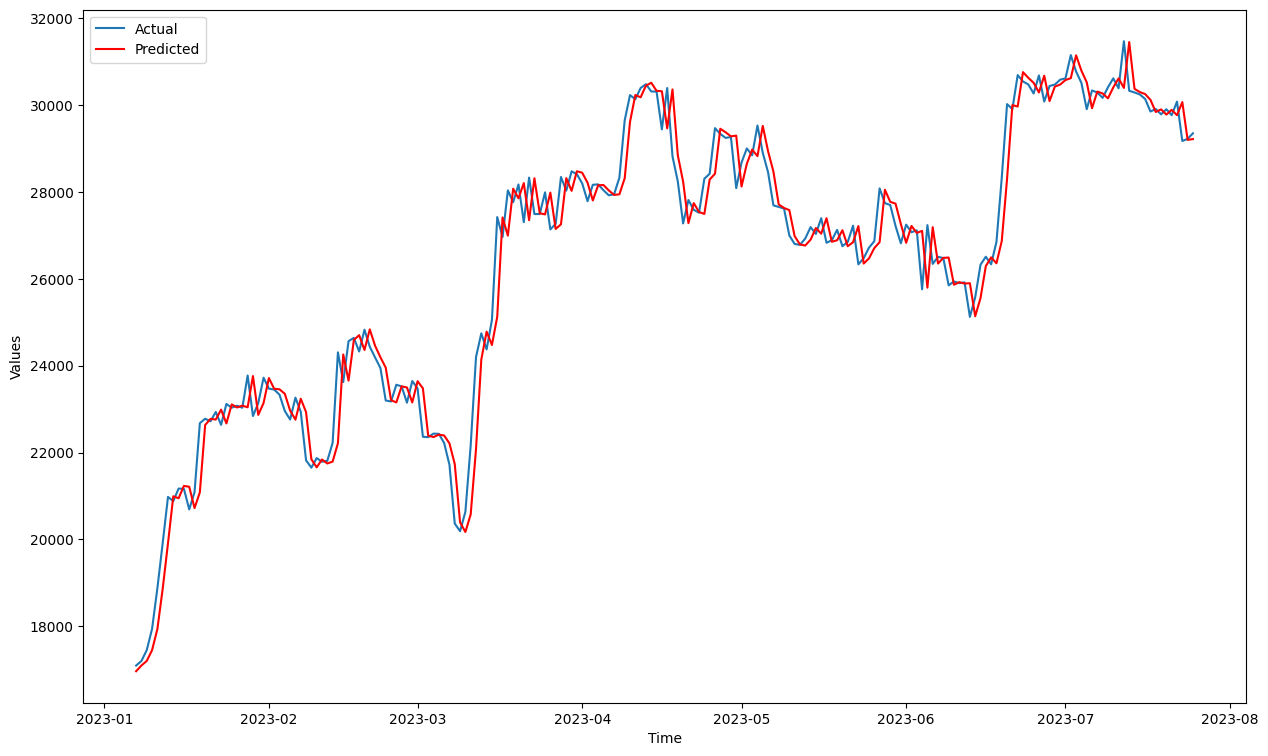

In [ ]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values_test = test_df['Actual'].iloc[start_index:end_index]
predicted_values_test = test_pred_df['Predicted'].iloc[start_index:end_index]
time_index_test = test_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index_test, actual_values_test, label='Actual')

# Plot predicted values in red
plt.plot(time_index_test, predicted_values_test, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

**b. Forecast Next 7 Days with ARIMA Model**

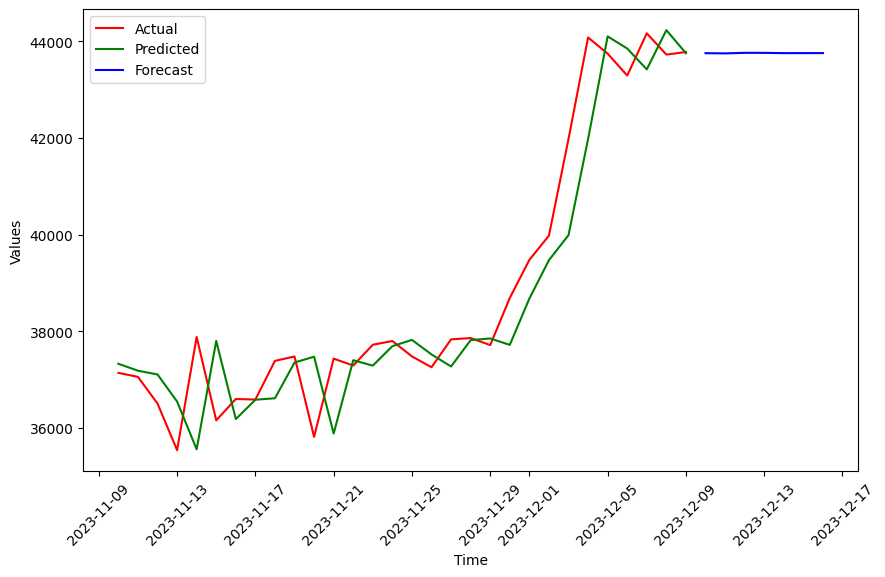

In [ ]:
# Forecast next 7 days
forecast_steps = 7
forecast = model_fit.forecast(steps=forecast_steps)

# Set the plot size
plt.figure(figsize=(10, 6))

# Plot only the last 30 data points
last_100_index = data['TargetNextClose'].index[-30:]

# Plot predicted values in red
plt.plot(last_100_index, test_df['Actual'].tail(30), color='red', label='Actual')

# Plot forecasted values in green
plt.plot(test_pred_df.index[-30:], test_pred_df['Predicted'].tail(30), color='green', label='Predicted')

# Plot forecasted values for the next 7 days in blue
forecast_index = pd.date_range(start=test_pred_df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
plt.plot(forecast_index, forecast, color='blue', label='Forecast')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Tilt x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.show()

We find a strong degree of consistency between the projections produced by the ARIMA model and the actual Bitcoin closing prices based on historical data from Yahoo. This attests to the ARIMA model's predictive power for Bitcoin prices.

**Conclusion:** High R-squared scores and low error metrics (MAE, MAPE) highlight the ARIMA model's remarkable accuracy in predicting Bitcoin prices, highlighting its capacity to precisely capture intricate patterns. In the future, the scope will include exploring more features to improve the model's understanding, implementing ensemble modeling to improve robustness, implementing real-time updates and optimization, utilizing Highcharts to create user-friendly visualizations, and integrating external datasets for a more thorough analysis. The overall goal of these initiatives is to improve the usefulness and relevance of models for predicting Bitcoin prices.

**References:**
 - Brownlee, J. (2023, November 18). How to create an Arima model for time series forecasting in Python. Retrieved from MachineLearningMastery.com: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
 - GeeksforGeeks. (2023, June 5). Understanding of LSTM networks. Retrieved from GeeksforGeeks: https://www.geeksforgeeks.org/understanding-of-lstm-networks/
 - Levi, K. L. (2023, May 22). Best 10 indicators for cryptocurrency trading: Primexbt&nbsp. Retrieved from PrimeXBT: https://primexbt.com/for-traders/best-indicators-for-cryptocurrency-trading/
 - Narayanan, A., Bonneau, J., Felten, E., Miller, A., & Goldfeder, S. (2016). Bitcoin and cryptocurrency technologies: a comprehensive introduction. Princeton University Press.
 - Tambe, N. (2023, December 6). Bitcoin price prediction: Can Bitcoin reach $1,000,000 by 2025? Retrieved from Forbes: https://www.forbes.com/advisor/in/investing/cryptocurrency/bitcoin-prediction/
 - Yahoo! (2023, December 19). Bitcoin USD (BTC-USD) price history &amp; historical data. Retrieved from Yahoo! Finance: https://finance.yahoo.com/quote/BTC-USD/history/?guccounter=1

